# Low Depth Quantum State Preparation Example (With COPY)

<span style="color:red;">Note: the current version of the Braket auto compiler will tend to automatically push all the quantum gates to the earliest instance when printing out the circuit. Thus, the theoretical advantages of waiting to allocate an ancilla qubit until later in the circuit will not be evident from the circuit outputs. )</span>

<span style="color:red;">Note: this example is a hard-coded circuit implementation, which does not generalized to arbitrary quantum state of size $n$. </span>

## Overall Structure

This notebook will provide a concrete example that utilizes our SP+CSP protocol (details described in https://arxiv.org/abs/2303.02131) to prepare an arbitrary quantum state of size $n = 3$, by first preparing an state with $m = 1$ qubits, and then performing a controlled state preparation from that $m$-qubit state into the full $n$-qubit state.  

<span style="color:orange;"> We recommend the reader to understand the circuit details in this notebook together with the paper and the other notebook (2+2 version). </span>

The core innovation of this work is to build on the work from Clader et al. (https://ieeexplore.ieee.org/document/10012045) and advance further to:


A. Expand $O(\log(N/\epsilon))$ T-depth to $O(\log(N/\epsilon))$ Clifford + T depth ($O(\log(N))$ depth using arbitrary single qubit gate + CNOT))

B. Achieve $O(N\log(\log(N)/\epsilon))$ spacetime allocation (metric defined in Sec. II of the paper) by allocating the ancillae at a later time, and subsequently freeing them up at an earlier time ($O(N)$ spacetime allocation using arbitrary single qubit gate + CNOT))

C. Allow some of the ancilla qubits to be dirty, i.e. they can begin in any arbitrary state and they will be returned to that state at the end of the circuit

(Note that $N = 2^n$)

All of the above mentioned complexity numbers are either better or equivalent to the best state-of-the-art methods.

We first prepare the quantum state $|\phi\rangle$ with $m=1$ qubits using the SP circuit:

$U\mathrm{_{SP}}$ $|0\rangle$ = $|\phi\rangle$ = $\frac{1}{\lVert \mathbf{y} \rVert}\sum_{i=0}^{1}y_i|i\rangle$

Then, we prepare the full state $|\psi\rangle$ with $n=3$ qubits using the CSP circuit:

$U_{\mathrm{CSP}}(|\phi\rangle \otimes |00\rangle) = |\psi\rangle = \frac{1}{\lVert \mathbf{x}\rVert}\sum_{j=0}^{7}x_j |j\rangle$

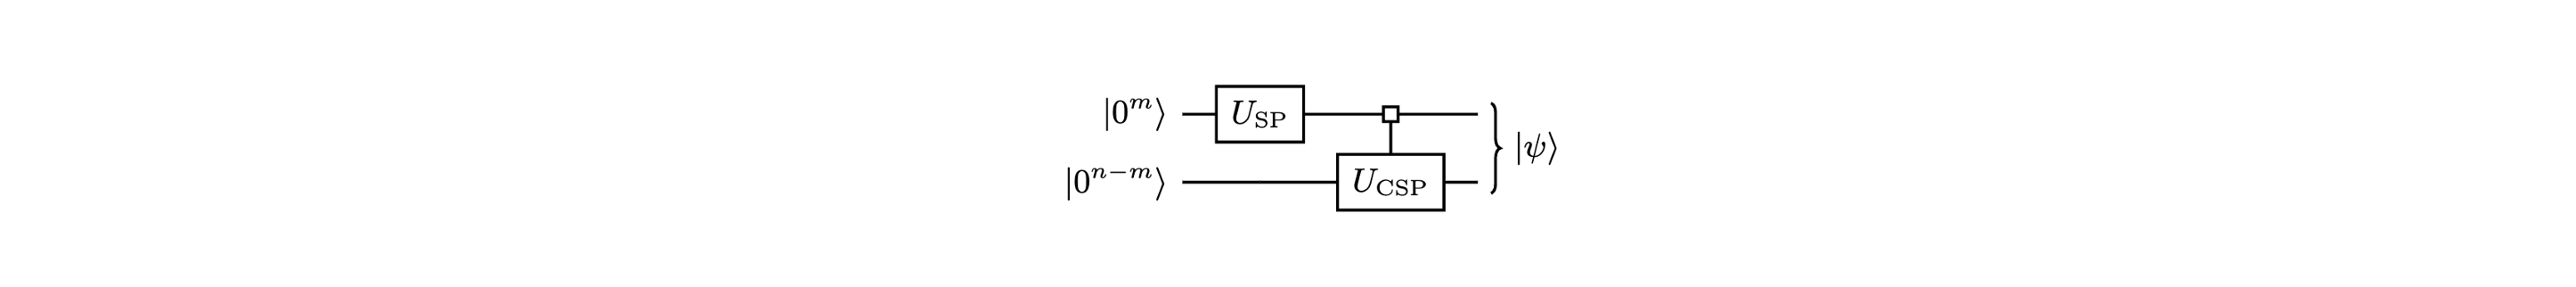

where $\mathbf{x} = [x_0, x_1, ..., x_{7}]$ is a vector of size $2^3 = 8$ that holds 8 non-negative real numbers

##### <span style="color:green;">The advantage of using the SP+CSP structure is to hopefully achieve optimality in both circuit depth and spacetime allocation (defined as Eq. 4 in the paper), which in the end saves us more quantum computing resources. </span>

(The SP part in this example is relatively simple and does not show the full picture, due to limitation of qubit numbers in the Braket simulator. We use this example to mainly demonstrate how the $\mathrm{COPY}$ operations are implemented while gauranteeing a non-trivial $\mathrm{LOADF}$ in the CSP part.)

We demonstrate a larger instance of the quantum state preparation protocol without $\mathrm{COPY}$ operations in another jupyter notebook.

In [1]:
# Import Braket libraries
import braket
from braket.circuits import Circuit
from braket.aws import AwsDevice
from braket.devices import LocalSimulator

import numpy as np
import math
import random
from typing import Tuple, Callable

from helper_functions import round_to_three_significant_digits, row_to_column_vector, generate_normalized_random_vec, binary_to_decimal

## Circuit Implementation

### Classical Part

#### Compute Angles

According to Algorithm 1 in the paper, we first classically compute the rotation angles using Eq. 8:

$\theta_{s,p} = 2\cos^{-1} \Bigg(\frac{\sqrt{\sum_{l=0}^{2^{m-s-1}-1}|x_{p2^{m-s}+l}|^2}}{\sqrt{\sum_{l=0}^{2^{m-s}-1}|x_{p2^{m-s}+l}|^2}}\Bigg)$

We can first define a function to calculate the values for each individual $s$ and $p$:

In [2]:
def compute_target_bit_angle(s: int, p: int, WF_array: np.ndarray) -> float:
    """
    Function to compute a particular theta_{s,p} angle according to the equation above
    
    @param s: as it appears in Eq. 8, also corresponds to the index of the ancilla register
    @param p: as it appears in Eq. 8, also corresponds to the index of the qubit within the particular ancilla register
    @param WF_array: the entire wave function array of x
    
    @return: a float/double value that holds the computed angle 
    """
    sum_top = 0.0
    m = int(math.log(len(WF_array), 2))
    for l in range(2 ** (m - s - 1) - 1 + 1): # compute the sum on the numerator
        current_var = WF_array[(p) * 2 ** (m - s) + l]
        sum_top += current_var ** 2
    
    sum_bottom = 0.0
    for l in range(2 ** (m - s) - 1 + 1): # compute the sum on the denominator
        current_var = WF_array[(p) * 2 ** (m - s) + l]
        sum_bottom += current_var ** 2
        
    if sum_bottom == 0: # edge case: arcsin denominator is zero
        return 0.0
    else:
        return 2 * np.arccos(np.sqrt(sum_top) / np.sqrt(sum_bottom))

Then loop over all the possible $s$ and $p$'s to get an array of angles:

In [3]:
def get_angle_array(WF_array: np.ndarray, m: int, n: int) -> Tuple[np.ndarray, np.ndarray]:
    """
    Function to get the angles arrays both SP and CSP circuit
    (Note that one may utilize the tree structure to optimize the classical cost)
    
    @param WF_array: the entire wave function array of x
    @param m: SP part data qubit count
    @param n: total data qubit count
    
    @return sp_angle_array: an array of size 2^m - 1 that holds the rotation angles for the SP part
    @return csp_angle_array: an array of size 2^n/2^m - 1 that holds toe roration angles for the CSP part
    """
    assert len(WF_array) == 2 ** n
    
    sp_angle_array = []
    csp_angle_array = []
    
    for s in range(m):
        for p in range(2 ** s):
            sp_angle_array.append(compute_target_bit_angle(s, p, WF_array))
    
    for s in range(m, n):
        for p in range(2 ** s):
            csp_angle_array.append(compute_target_bit_angle(s, p, WF_array))
    
    return np.array(sp_angle_array), np.array(csp_angle_array)

#### Generate Random Vector

Now let's generate 8 normalized non-negative real values using the helper function:

In [4]:
%%time 
# this currently scale as O(2^2n), can be optimized to O(2^n) for large n values
n = 3 # number of data qubits. We can encode 2^n number of values with n qubits!
random.seed(10) # fix a seed for data reproduction purpose, you can change this value to play with other results
WF_array = generate_normalized_random_vec(n)
print(WF_array) # print out the wave function vector array for validation

[0.34906556 0.26200511 0.35315164 0.12590386 0.49685185 0.50312427
 0.39920147 0.09788303]
CPU times: user 252 µs, sys: 56 µs, total: 308 µs
Wall time: 306 µs


#### Put Both Parts Together

Using the generated vector, we can now get the angle arrays for the SP and CSP parts:

In [5]:
m = 1
n = 3
sp_angle_array, csp_angle_array = get_angle_array(WF_array, m, n)
print(sp_angle_array)
print(csp_angle_array)

[1.91545707]
[1.41941417 1.05308496 1.28775716 0.68493403 1.58334129 0.48090637]


With the classical part done, let's now begin to look at the quantum part!

### Quantum Part

In this example, we pre-allocate the ancilla qubits for simplicity and consistency. In the actual algorithm implementation scenario, one can allocate the ancilla qubits dynamically (i.e., ancilla qubits can be allocated for a different task once it is freed from the previous task).

We first allocate qubit #0 - qubit #5 ($q0$ - $q5$) as the $D$ register. Note that $q0$ holds the state $|\phi\rangle$, $q0$ - $q2$ hold the state $|\psi\rangle$, and $q3$ - $q5$ are used for ancilla qubits to assist parallelized CSWAP gates.

#### SP Circuit Implementation

<span style="color:orange;">The SP circuit for this example is relatively easy, we only need 1 Ry gate and 1 SWAP gate in $SPF$. We don't need to add the uncomputation part ($\mathrm{FLAG}$-$\mathrm{CRy}$-$\mathrm{FLAG}$$^{\dagger}$) because the ancilla qubits in the register are all swapped into the data qubits. See the other example note book (2+2 version) to see a full implementation of the SP circuit.</span>

We allocate $q6$ to be the $A$ register. No qubit allocation is needed for the $F$ register.

In [6]:
def SP_circ(circ: braket.circuits.circuit.Circuit):
    circ.ry(angle=sp_angle_array[0], target=6)
    circ.swap(0, 6)
    
SP_circuit = Circuit()
SP_circ(SP_circuit)
print(SP_circuit)

T  : |   0    | 1  |
                    
q0 : ----------SWAP-
               |    
q6 : -Ry(1.92)-SWAP-

T  : |   0    | 1  |


Click this [example](https://algassert.com/quirk#circuit={%22cols%22:[[{%22id%22:%22Ryft%22,%22arg%22:%221%22},1,1,{%22id%22:%22Ryft%22,%22arg%22:%223%22},{%22id%22:%22Ryft%22,%22arg%22:%222%22},{%22id%22:%22Ryft%22,%22arg%22:%227%22},{%22id%22:%22Ryft%22,%22arg%22:%226%22},{%22id%22:%22Ryft%22,%22arg%22:%225%22},{%22id%22:%22Ryft%22,%22arg%22:%224%22},%22X%22,%22X%22,%22X%22,%22X%22,%22X%22,%22X%22],[%22%E2%80%A2%22,1,1,%22Swap%22,%22Swap%22],[%22%E2%80%A2%22,1,1,1,1,%22Swap%22,1,%22Swap%22],[%22%E2%80%A2%22,1,1,1,1,1,%22Swap%22,1,%22Swap%22],[1,%22Swap%22,1,%22Swap%22],[1,%22%E2%80%A2%22,1,1,1,%22Swap%22,%22Swap%22],[1,1,%22Swap%22,1,1,%22Swap%22],[1,%22%E2%80%A2%22,1,1,1,%22Swap%22,%22Swap%22],[%22%E2%80%A2%22,1,1,%22Swap%22,%22Swap%22],[%22%E2%80%A2%22,1,1,1,1,%22Swap%22,1,%22Swap%22],[%22%E2%80%A2%22,1,1,1,1,1,%22Swap%22,1,%22Swap%22],[1,1,1,1,1,1,1,1,1,%22X%22,1,%22X%22],[1,%22%E2%80%A2%22,1,1,1,1,1,1,1,1,1,%22Swap%22,%22Swap%22],[%22%E2%80%A2%22,1,1,1,1,1,1,1,1,%22Swap%22,%22Swap%22],[%22%E2%80%A2%22,1,1,1,1,1,1,1,1,1,1,%22Swap%22,1,%22Swap%22],[%22%E2%80%A2%22,1,1,1,1,1,1,1,1,1,1,1,%22Swap%22,1,%22Swap%22],[1,1,1,{%22id%22:%22Ryft%22,%22arg%22:%22-3%22},1,1,1,1,1,%22%E2%80%A2%22],[1,1,1,1,{%22id%22:%22Ryft%22,%22arg%22:%22-2%22},1,1,1,1,1,%22%E2%80%A2%22],[1,1,1,1,1,{%22id%22:%22Ryft%22,%22arg%22:%22-7%22},1,1,1,1,1,%22%E2%80%A2%22],[1,1,1,1,1,1,{%22id%22:%22Ryft%22,%22arg%22:%22-6%22},1,1,1,1,1,%22%E2%80%A2%22],[1,1,1,1,1,1,1,{%22id%22:%22Ryft%22,%22arg%22:%22-5%22},1,1,1,1,1,%22%E2%80%A2%22],[1,1,1,1,1,1,1,1,{%22id%22:%22Ryft%22,%22arg%22:%22-4%22},1,1,1,1,1,%22%E2%80%A2%22],[%22%E2%80%A2%22,1,1,1,1,1,1,1,1,%22Swap%22,%22Swap%22],[%22%E2%80%A2%22,1,1,1,1,1,1,1,1,1,1,%22Swap%22,1,%22Swap%22],[%22%E2%80%A2%22,1,1,1,1,1,1,1,1,1,1,1,%22Swap%22,1,%22Swap%22],[1,%22%E2%80%A2%22,1,1,1,1,1,1,1,1,1,%22Swap%22,%22Swap%22],[1,1,1,1,1,1,1,1,1,%22X%22,1,%22X%22],[1,1,1,1,1,1,1,1,1,%22X%22,%22X%22,%22X%22,%22X%22,%22X%22,%22X%22]]}) to see the circuit implementation for a larger (m = 3) case of SP circuit

#### CSP Circuit Implementation

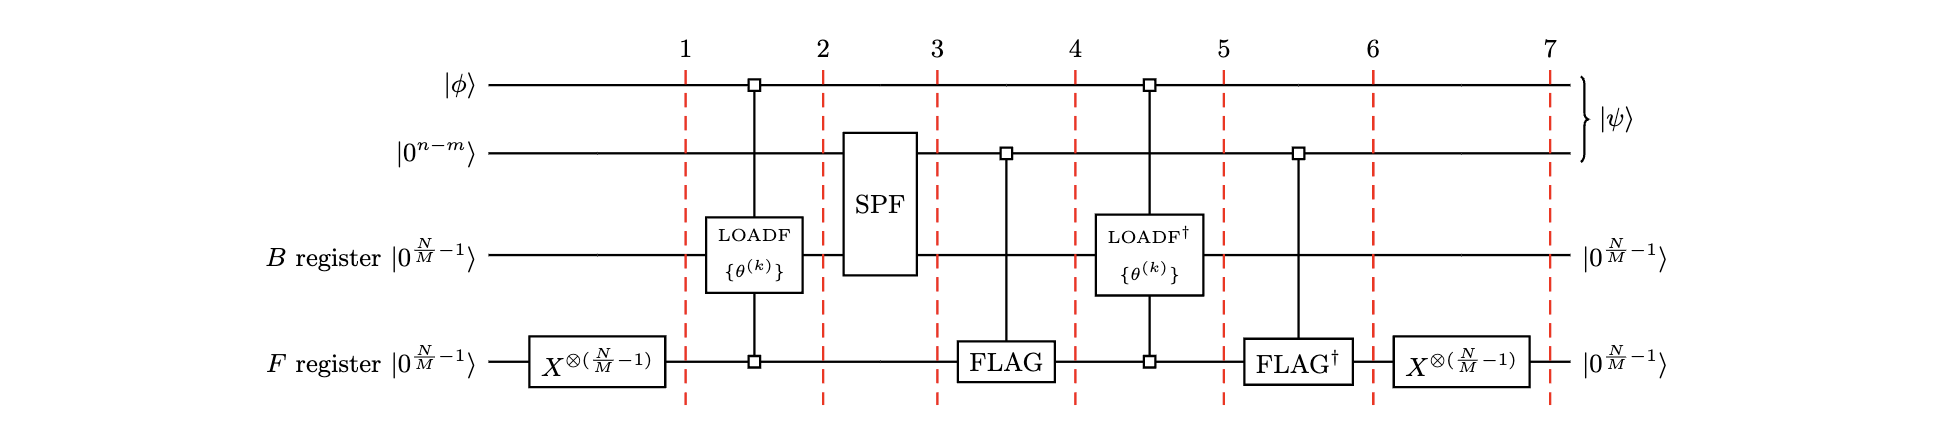

we allocate $q6$ - $q11$ for the $B$ register ($q6$ is freed up from SP circuit so can be reallocated here), $q12$ - $q17$ for the $A$ register, $q18$ - $q23$ for the $F$ register.

<span style="color:orange;">We also note that majority of the $B$ register ($q6$ - $q11$) can also be allocated from dirty qubits (i.e., don't necessarily need to be in the $|0\rangle$ states)! </span>

First an easy step for the parallelized X sequence:

In [7]:
def parellelized_X_CSP(circ: braket.circuits.circuit.Circuit):
    circ.x(18)
    circ.x(19)
    circ.x(20)
    
csp_circ1 = Circuit()
parellelized_X_CSP(csp_circ1)
print(csp_circ1)

T   : |0|
         
q18 : -X-
         
q19 : -X-
         
q20 : -X-

T   : |0|


Now the $\mathrm{LOADF}$ operation.

##### <span style="color:green;">This is where the magic happens! That is, we can effectively pump in $O(N)$ parallelized angles using only $O(\log(N))$ depth and $O(N)$ spacetime allocation! </span>

Specifically, $\mathrm{LOADF}$ will pump the parallelized $O(N - M)$ angles into $O(\frac{N}{M})$ ($\tilde{B}$) qubits.

We can implement it using the $\mathrm{Setup}$-$\mathrm{CCRy}$-$\mathrm{Setup}$$^{\dagger}$ structure, depicted in the upper right of the following picture:

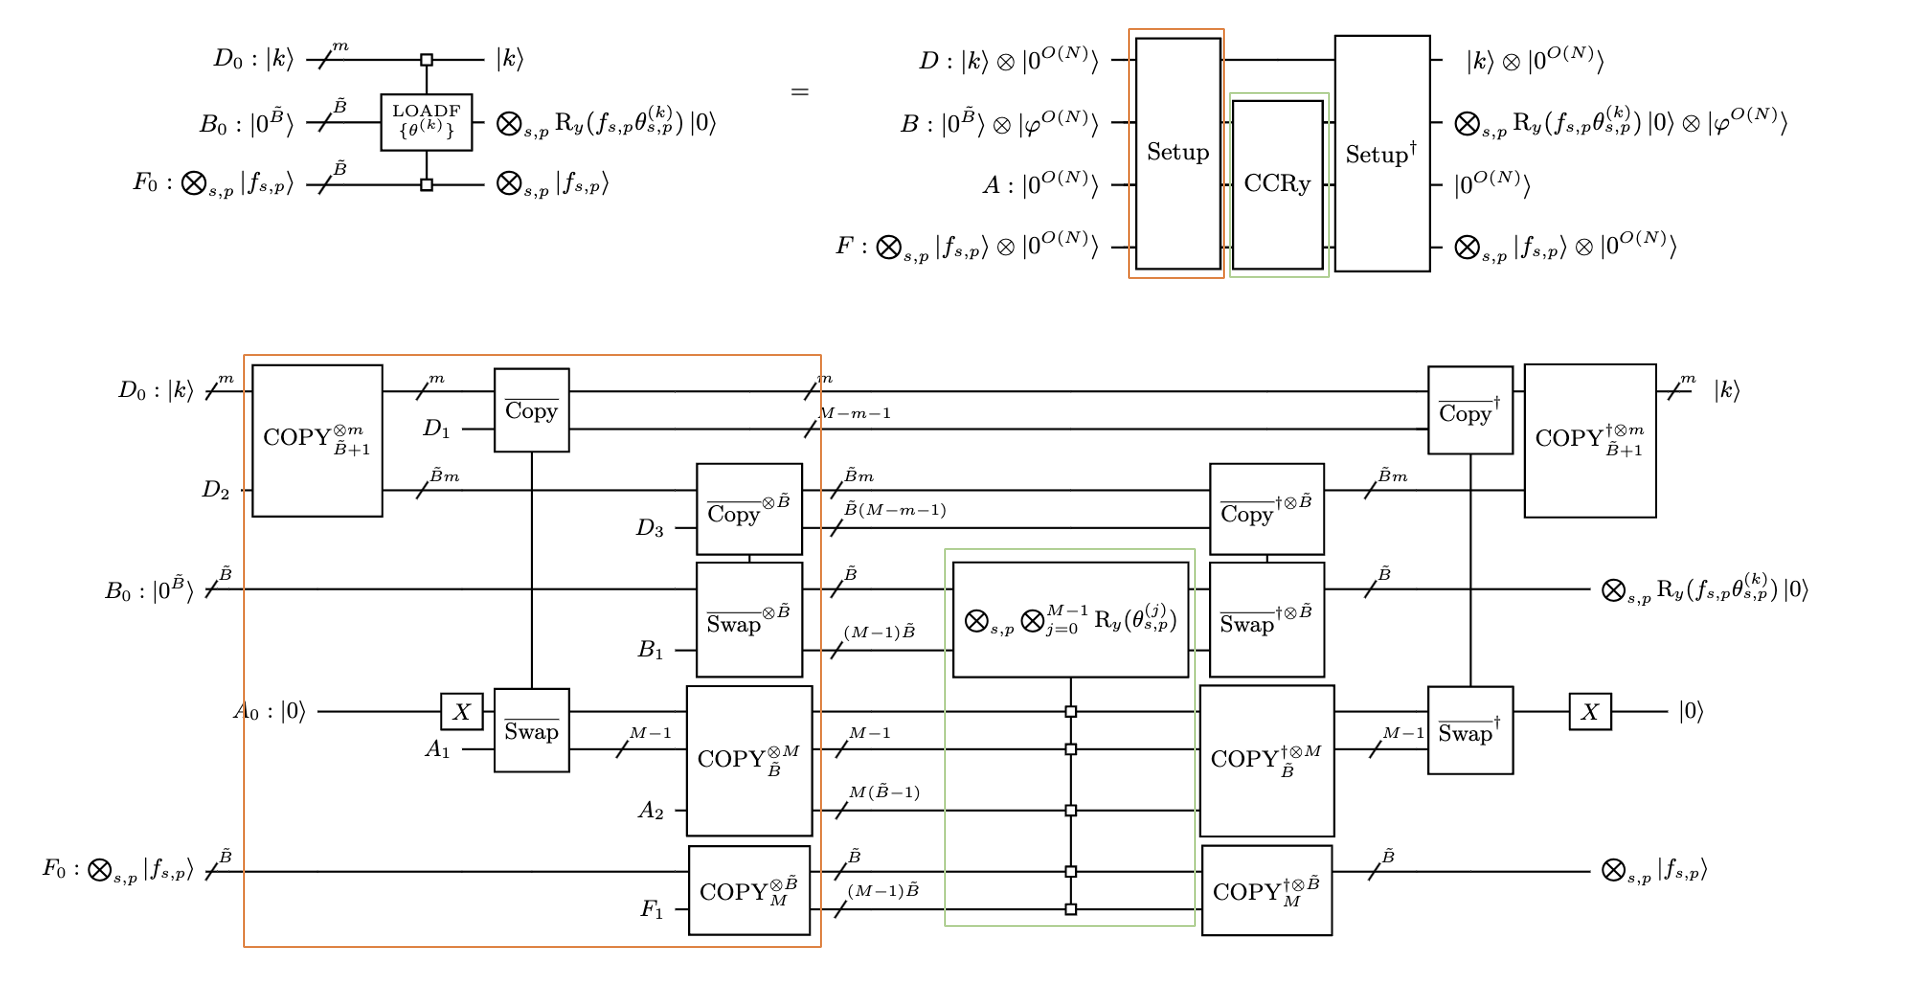

(recall that $M = 2^m$, and $m$ represents the number of data qubits in the $U_{\mathrm{SP}}$ operation. $N = 2^n$, and $n$ represent the number of data qubits in the $U_{\mathrm{CSP}}$ operation.)

Let see how $\mathrm{Setup}$ is implemented. Basically, it covers all the operations in the orange box on the left. The goal of $\mathrm{Setup}$ is to set up the expanded address in preparation for the $\mathrm{CCRy}$ sequence to load in all the angles conditioned on the $|k\rangle$ state. $\mathrm{COPY}$ steps are needed to ensure that the CSWAP gates in $\overline{\mathrm{CopySwap}}$ and CCRy gates in the $\mathrm{CCRy}$ sequence can be effectively parallelized (see paper for more details).

In [8]:
def Setup(circ: braket.circuits.circuit.Circuit):
    # the following insturctions correspond to the first m paralleled COPY of size \tilde{B} + 1
    circ.cnot(0, 3)
    circ.cnot(0, 4)
    circ.cnot(0, 5)
    
    circ.x(12)
    # the following instructions correspond to the first CopySwap operation
    circ.cswap(0, 12, 13)
    
    # the following instructions correspond to the \tilde{B} paralleled CopySwap's acting on the B register (q6 - q11)
    # Note that no additional COPY's are needed in this case since we only have 3 paralleled CS_0's (see Fig. 19 for the definition of CopySwap)
    circ.cswap(3, 6, 7)
    circ.cswap(4, 8, 10)
    circ.cswap(5, 9, 11)
    
    # the following block of instructions correspond to M paralleled COPY of size \tilde{B} acting on the A register (q12 - q17)
    # note that we can parallelize the following 4 CNOTs in 2 steps
    # q12's control info is copied into q14 and q15
    circ.cnot(12, 14)
    circ.cnot(12, 15)
    # q13's control info is copied into q16 and q17
    circ.cnot(13, 16)
    circ.cnot(13, 17)
    
    # the following block of instructions correspond to \tilde{B} paralleled COPY of size M acting on the F register (q18 - q23)
    # note that all 3 CNOTs can be parallelized in 1 step
    # q18's control info is copied into q21
    circ.cnot(18, 21)
    # q19's control info is copied into q22
    circ.cnot(19, 22)
    # q20's control info is copied into q23
    circ.cnot(20, 23)

##### <span style="color:green;">For larger instances, we can more effectively parallelize the CNOT gates in the $\mathrm{COPY}$ operations, achieving $O(\log(N))$ depth for $O(N)$ CNOTs. In other words, we introduce some additional CNOTs to help parallelize the CCRy gates with only $\textbf{constant}$ factors of depth and spacetime allocation introduced! </span>

In [9]:
csp_circ2a = Circuit()
Setup(csp_circ2a)
print(csp_circ2a)

T   : |  0  |  1   |  2   |    3    | 4 | 5 |
                                             
q0  : -C-----C------C------C-----------------
       |     |      |      |                 
q3  : -X-----|-C----|------|-----------------
             | |    |      |                 
q4  : -------X-|----|-C----|-----------------
               |    | |    |                 
q5  : ---------|----X-|----|----C------------
               |      |    |    |            
q6  : ---------SWAP---|----|----|------------
               |      |    |    |            
q7  : ---------SWAP---|----|----|------------
                      |    |    |            
q8  : ----------------SWAP-|----|------------
                      |    |    |            
q9  : ----------------|----|----SWAP---------
                      |    |    |            
q10 : ----------------SWAP-|----|------------
                           |    |            
q11 : ---------------------|----SWAP---------
                           |      

With $\mathrm{Setup}$ implemented, now we can use the $\mathrm{CCRy}$ operation (depicted as the green box in the middle) to load all the angles in parallel.

In [10]:
def paralellized_CCRy(circ: braket.circuits.circuit.Circuit):
    circ.ry(angle=csp_angle_array[0], target=6, control=(12, 18))
    circ.ry(angle=csp_angle_array[1], target=7, control=(13, 21))
    circ.ry(angle=csp_angle_array[2], target=8, control=(14, 19))
    circ.ry(angle=csp_angle_array[3], target=9, control=(15, 20))
    circ.ry(angle=csp_angle_array[4], target=10, control=(16, 22))
    circ.ry(angle=csp_angle_array[5], target=11, control=(17, 23))

In [11]:
csp_circ2b = Circuit()
paralellized_CCRy(csp_circ2b)
print(csp_circ2b)

T   : |                          0                          |
                                                             
q6  : -Ry(1.42)----------------------------------------------
       |                                                     
q7  : -|--------Ry(1.05)-------------------------------------
       |        |                                            
q8  : -|--------|--------Ry(1.29)----------------------------
       |        |        |                                   
q9  : -|--------|--------|--------Ry(0.68)-------------------
       |        |        |        |                          
q10 : -|--------|--------|--------|--------Ry(1.58)----------
       |        |        |        |        |                 
q11 : -|--------|--------|--------|--------|--------Ry(0.48)-
       |        |        |        |        |        |        
q12 : -C--------|--------|--------|--------|--------|--------
       |        |        |        |        |        |        
q13 : -|

Note that $\mathrm{Setup}$$^{\dagger}$ operation is the adjoint operation of $\mathrm{Setup}$. Luckily, Braket provides a adjoint function that can save us from implementing it in the reverse order! We now define a generalized adjoint operation function, that is also good for future adjoint operations defined later in this notebook.

In [12]:
def add_adjoint_operation(original_circ_func: Callable[[braket.circuits.circuit.Circuit], None], circ: braket.circuits.circuit.Circuit):
    prev_circ = Circuit()
    original_circ_func(prev_circ)
    prev_circ_adjoint = prev_circ.adjoint()
    adjoint_instruction = prev_circ_adjoint.instructions
    circ.add(adjoint_instruction)

Now assemble $\mathrm{Setup}$, $\mathrm{CCRy}$, $\mathrm{Setup}$$^{\dagger}$ (using adjoint of $\mathrm{Setup}$) together to form the $\mathrm{LOADF}$ operation:

In [13]:
def LOADF(circ: braket.circuits.circuit.Circuit):
    Setup(circ)
    paralellized_CCRy(circ)
    add_adjoint_operation(Setup, circ)

In [14]:
csp_circ2 = Circuit()
LOADF(csp_circ2)
print(csp_circ2)

T   : |  0  |  1   |  2   |    3    | 4 |          5          |                 6                 |    7    | 8 | 9  |10|11|12|
                                                                                                                               
q0  : -C-----C------C------C-------------------------------------------------------------------------------------C----C--C--C--
       |     |      |      |                                                                                     |    |  |  |  
q3  : -X-----|-C----|------|----------------------------------------------------------------------------C--------|----|--|--X--
             | |    |      |                                                                            |        |    |  |     
q4  : -------X-|----|-C----|--------------------------------------------------------------C-------------|--------|----|--X-----
               |    | |    |                                                              |             

The $\mathrm{SPF}$ and $\mathrm{FLAG}$ are the same as those in the SP circuit (see paper and the other notebook (2+2 version) for details on $\mathrm{SPF}$ and $\mathrm{FLAG}$):

In [15]:
def SPF_CSP(circ: braket.circuits.circuit.Circuit):
    circ.swap(1, 6)
    circ.cswap(1, 8, 9)
    circ.swap(2, 8)
    circ.cswap(1, 8, 9)
    
csp_circ3 = Circuit()
SPF_CSP(csp_circ3)
print(csp_circ3)

T  : | 0  | 1  | 2  | 3  |
                          
q1 : -SWAP-C---------C----
      |    |         |    
q2 : -|----|----SWAP-|----
      |    |    |    |    
q6 : -SWAP-|----|----|----
           |    |    |    
q8 : ------SWAP-SWAP-SWAP-
           |         |    
q9 : ------SWAP------SWAP-

T  : | 0  | 1  | 2  | 3  |


In [16]:
def FLAG_CSP(circ: braket.circuits.circuit.Circuit):
    circ.x(18)
    circ.x(19)
    circ.cswap(1, 19, 20)
    
csp_circ4 = Circuit()
FLAG_CSP(csp_circ4)
print(csp_circ4)

T   : |0| 1  |
              
q1  : ---C----
         |    
q18 : -X-|----
         |    
q19 : -X-SWAP-
         |    
q20 : ---SWAP-

T   : |0| 1  |


Now assemble all the operations to form the CSP circuit ($U\mathrm{_{CSP}}$). Note that e.g. $\mathrm{LOADF}^{\dagger}$ can be done by simple calling the adjoint of $\mathrm{LOADF}$

In [17]:
def CSP_circ(circ: braket.circuits.circuit.Circuit):
    parellelized_X_CSP(circ)
    LOADF(circ)
    SPF_CSP(circ)
    FLAG_CSP(circ)
    add_adjoint_operation(LOADF, circ)
    add_adjoint_operation(FLAG_CSP, circ)
    parellelized_X_CSP(circ)

Finally, let's put SP circuit and CSP circuit together!

(You can also try to print out the entire circuit, but it might be a little large to display)

In [18]:
circ = Circuit()
SP_circ(circ)
CSP_circ(circ)
# print(circ)

## Circuit Execution Using Braket's LocalSimulator

Now, let test our circuit's output result. We first define our simulator as:

In [19]:
%%time
# Run the circuit and get the state vector output
from braket.devices import LocalSimulator
braket_device = LocalSimulator()
circ.state_vector()
braket_state_vector_result = braket_device.run(circ, shots=0).result()
result_vec_1d = braket_state_vector_result.values[0]

This program uses OpenQASM language features that may not be supported on QPUs or on-demand simulators.


CPU times: user 1min 4s, sys: 18.9 s, total: 1min 23s
Wall time: 14.4 s


We need to do the digit conversion below to exactly extract the states for the first 3 qubits (the other qubits are the ancilla bits uncomputed to the $|0\rangle$ states and thus should not carry any amplitudes).

In [20]:
def get_data_qubit_index_array(m: int, n: int) -> np.ndarray:
    """
    Function to get the decimal indices for the basis with ancilla qubits all in the |0> states
    
    @param m: number of data qubits involved
    @param n: number of total qubits involved
    
    @return data_qubit_index_array: an array that represent all the indices in the decimal form
    """
    data_qubit_index_array = []
    for i in range(2 ** m):
        data_binary_str = format(i, '03b')  # Format 'i' as a binary string
        total_binary_str = data_binary_str + ('0' * (n - m)) # concatenate the remaining zeros on the ancilla qubits
        data_qubit_index_array.append(binary_to_decimal(total_binary_str))
    return np.array(data_qubit_index_array)

In [21]:
data_qubit_index_array = get_data_qubit_index_array(3, 24)
state_vector_array_converted = []
for num in data_qubit_index_array:
    state_vector_array_converted.append(result_vec_1d[num])

Let's print out the results. We round the number of digits to 3, and use a row to column vector converter to make things look nice.

In [22]:
print('The first 8 elements of the state vector are:')
print(row_to_column_vector(round_to_three_significant_digits(state_vector_array_converted, 3)))
print()
print('Also to make sure there is no leftover amplitude in other states, let\'s compute the sum of the squared amplitudes of the first 8 elements:')
print(np.dot(state_vector_array_converted, state_vector_array_converted))

The first 8 elements of the state vector are:
[[0.349+0.j]
 [0.262+0.j]
 [0.353+0.j]
 [0.126+0.j]
 [0.497+0.j]
 [0.503+0.j]
 [0.399+0.j]
 [0.098+0.j]]

Also to make sure there is no leftover amplitude in other states, let's compute the sum of the squared amplitudes of the first 8 elements:
(0.9999999999999998+0j)


Printing out the wave function array again:

In [23]:
print(row_to_column_vector(round_to_three_significant_digits(WF_array, 3)))

[[0.349]
 [0.262]
 [0.353]
 [0.126]
 [0.497]
 [0.503]
 [0.399]
 [0.098]]


Let's see the actual difference between the expected amplitude vector vs what is actually produced

In [24]:
print(row_to_column_vector(np.array(state_vector_array_converted) - np.array(WF_array)))

[[ 5.55111512e-17+0.j]
 [ 5.55111512e-17+0.j]
 [ 1.66533454e-16+0.j]
 [ 5.55111512e-17+0.j]
 [-5.55111512e-17+0.j]
 [-2.22044605e-16+0.j]
 [ 0.00000000e+00+0.j]
 [-1.38777878e-17+0.j]]


The result matches perfectly with the desired output!

#### Printing out Braket SDK version for debugging:

In [25]:
import braket._sdk as braket_sdk
braket_sdk.__version__

'1.55.0'

In [26]:
from platform import python_version
print(python_version())

3.10.11
